# Figure S2 | CCFv3 registration errors impact alignment between thalamic nuclei and transcriptomic types.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import sys
sys.path.append('/code/')
from abc_merfish_analysis import abc_load as abc
from abc_merfish_analysis import ccf_images as cimg
from abc_merfish_analysis import ccf_erode as cerode
from abc_merfish_analysis import ccf_plots as cplots

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import colorcet as cc

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline') 

In [2]:
# set global matplotlib params
from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

In [3]:
results_dir = '../../results'

## Load thalamus data

In [4]:
# Load the full thalamus anndata object
obs_th = abc.load_standard_thalamus(data_structure='obs')

# Subset to just the left hemisphere
obs_th_left = obs_th[obs_th['left_hemisphere']].copy()

In [5]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

In [6]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

# Merge substructures into structures (esp. AMd + AMv -> AM; LGd-co + LGd-ip + LGd-sh -> LG)
ccf_images = cerode.merge_substructures(ccf_images, ccf_level='structure')

# Precompute boundaries to use multiple times in this notebook w/o need to recompute
# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(obs_th[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [7]:
# Load the CCF structures image - just the left hemisphere
ccf_images_left = abc.get_ccf_labels_image(subset_to_left_hemi=True)

# Merge substructures into structures (esp. AMd + AMv -> AM; LGd-co + LGd-ip + LGd-sh -> LG)
ccf_images_left = cerode.merge_substructures(ccf_images_left, ccf_level='structure')

# Precompute boundaries to use multiple times in this notebook w/o need to recompute
# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(obs_th_left[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries_left = cimg.sectionwise_label_erosion(ccf_images_left, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [8]:
# if you reload abc_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

In [9]:
# load the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
# TODO: once released as package, this won't be accessible through a hardcode
palette_df = pd.read_csv('/code/abc_merfish_analysis/resources/cluster_palette_glasbey.csv')
abc_palettes['cluster'] = dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

## Highlight cells from two subclasses

In [10]:
# Highlight three midline and interlaminar nuclei
nuclei_mid_interlam = ['IAD', 'IMD', 'PCN']

In [11]:
# Select 6 example sections, from anterior to posterior
sections_mid_interlam = [8.0, 7.8, 7.6, 7.2, 7.0, 6.8, 6.6] 

print(f'sections as {z_col}: {sections_mid_interlam}')
print(f'sections as brain_section_label: {abc.convert_section_list(sections_mid_interlam)}')

sections as z_reconstructed: [8.0, 7.8, 7.6, 7.2, 7.0, 6.8, 6.6]
sections as brain_section_label: ['C57BL6J-638850.44', 'C57BL6J-638850.43', 'C57BL6J-638850.42', 'C57BL6J-638850.40', 'C57BL6J-638850.39', 'C57BL6J-638850.38', 'C57BL6J-638850.37']


In [12]:
# Highlight cells from subclass 150 and 151
taxonomy_level = 'subclass'
obs_plot = obs_th_left.copy()
obs_plot = obs_plot[obs_plot[taxonomy_level].str.contains('150|151', regex=True)]
obs_plot.loc[:,taxonomy_level] = obs_plot.loc[:,taxonomy_level].cat.remove_unused_categories()

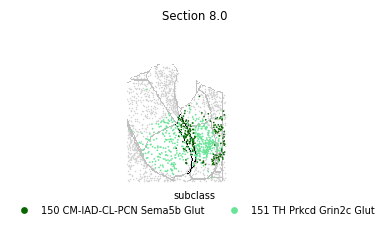

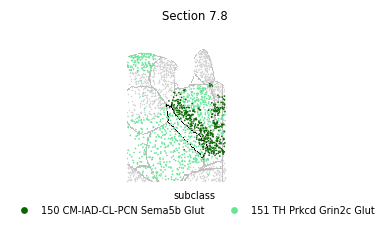

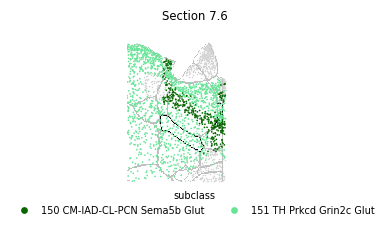

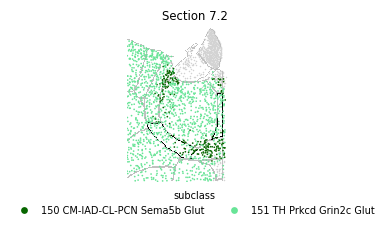

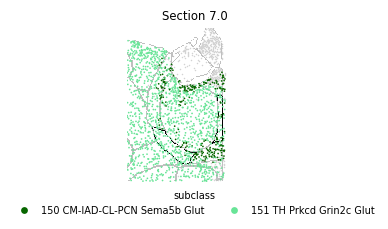

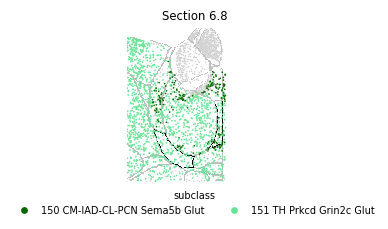

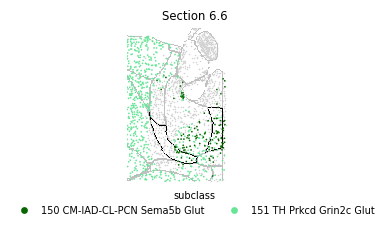

In [13]:
# set kwargs fpr annotated cluster plots
kwargs_cluster_annotations = dict(
    section_col=z_col,
    x_col=x_col,
    y_col=y_col,
    point_size=1.5,
    figsize=(4, 2),
    face_palette=None,
    edge_color='silver',
    custom_xy_lims=[4.25,6, 6.25,4.25]
    )

# get the cluster annotations for the nucleus of interest
# nucleus = nuclei_mid_interlam
sections_to_plot = sections_mid_interlam # None
nuclei_highlight = nuclei_mid_interlam

plt.rcParams.update({'font.size': 7})
figs_annot = cplots.plot_ccf_overlay(obs_plot, 
                                    ccf_images_left,
                                    boundary_img=ccf_boundaries_left,
                                    bg_cells=obs_th_left, 
                                    ccf_highlight=nuclei_highlight,
                                    point_hue=taxonomy_level, 
                                    sections=sections_to_plot,
                                    point_palette=abc_palettes[taxonomy_level],
                                    legend='cells',
                                    # show_axes=True,
                                    **kwargs_cluster_annotations)

for i, sec in enumerate(sections_to_plot):
    figs_annot[i].savefig(f'{results_dir}/figSX_{taxonomy_level}_150_151_z{sec}_midline_interlam.pdf', 
                          transparent=True, bbox_inches='tight')
    figs_annot[i].savefig(f'{results_dir}/figSX_{taxonomy_level}_150_151_z{sec}_midline_interlam.png', 
                          transparent=True, bbox_inches='tight', dpi=1200)